In [2]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.utils.data.dataloader as dataloader

In [3]:
LeNet=nn.Sequential(
    nn.Conv2d(1,6,kernel_size=5,padding=2),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Conv2d(6,16,kernel_size=5),nn.Sigmoid(),
    nn.AvgPool2d(kernel_size=2,stride=2),
    nn.Flatten(),
    nn.Linear(5*5*16,120),nn.Sigmoid(),
    nn.Linear(120,84),nn.Sigmoid(),
    nn.Linear(84,10)
)
# 去掉了最后一层的高斯激活

In [4]:
# 下载MNIST 数据集
path='.'
mnist=datasets.MNIST(root=path,train=True,download=True,transform=transforms.ToTensor())

Using downloaded and verified file: .\MNIST\raw\train-images-idx3-ubyte.gz
Extracting .\MNIST\raw\train-images-idx3-ubyte.gz to .\MNIST\raw

Using downloaded and verified file: .\MNIST\raw\train-labels-idx1-ubyte.gz
Extracting .\MNIST\raw\train-labels-idx1-ubyte.gz to .\MNIST\raw

Using downloaded and verified file: .\MNIST\raw\t10k-images-idx3-ubyte.gz
Extracting .\MNIST\raw\t10k-images-idx3-ubyte.gz to .\MNIST\raw

Using downloaded and verified file: .\MNIST\raw\t10k-labels-idx1-ubyte.gz
Extracting .\MNIST\raw\t10k-labels-idx1-ubyte.gz to .\MNIST\raw



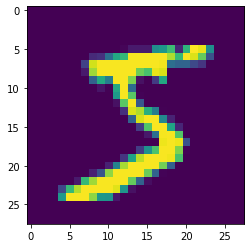

In [6]:
import matplotlib.pyplot as plt
img,label=mnist[0]
plt.imshow(img.permute(1,2,0))
plt.show()

In [7]:
print(img.shape,label)

torch.Size([1, 28, 28]) 5


In [8]:
batch_size=256
train_data=datasets.MNIST('.',train=True,download=True,transform=transforms.ToTensor())
test_data=datasets.MNIST('.',train=False,download=True,transform=transforms.ToTensor())
train_loader=dataloader.DataLoader(train_data,batch_size=batch_size,shuffle=True)
test_loader=dataloader.DataLoader(test_data,batch_size=batch_size,shuffle=False)

In [15]:
# 训练

def cal(outputs,Y):
    pred=torch.argmax(outputs,dim=1)
    correct=(pred==Y).sum().item()
    return correct


def test_loop(net,device,test_loader,loss_fn):
    net.eval()
    test_acc=0
    test_loss=0
    net=net.to(device)
    with torch.no_grad():
        total=0
        correct=0
        for X,Y in test_loader:
            X,Y=X.to(device),Y.to(device)
            outputs=net(X)
            loss=loss_fn(outputs,Y)
            test_loss+=loss.item()
            total+=Y.size(0)
            correct+=cal(outputs,Y)
        test_acc=correct/total
    net.train()
    return 100*test_acc,test_loss


def train_loop(net,device,train_loader,test_loader,optimizer,loss_fn,epochs=100):
    net.train()
    train_acc=[]
    train_loss=[]
    test_acc=[]
    test_loss=[]
    net=net.to(device)
    for epoch in range(epochs):
        epoch_loss=0
        correct=0
        total=0
        for i,(X,Y) in enumerate(train_loader):
            X,Y=X.to(device),Y.to(device)
            outputs=net(X)
            loss=loss_fn(outputs,Y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss+=loss.item()
            total+=Y.size(0)
            correct+=cal(outputs,Y)

        train_acc.append(100*correct/total)
        train_loss.append(epoch_loss)
        acc,loss=test_loop(net,device,test_loader,loss_fn)
        test_acc.append(acc)
        test_loss.append(loss)
        if epoch==epochs-1:
            print(f'train acc = {train_acc[-1]}, test acc = {test_acc[-1]}')

    plt.subplot(2,1,1)
    plt.title('acc')
    plt.plot(train_acc,label='train')
    plt.plot(test_acc,label='test')

    # plt.subplot(2,1,2)
    # plt.title('loss')
    # plt.plot(train_loss,label='train')
    # plt.plot(test_loss,label='test')

cuda
train acc = 97.66333333333333, test acc = 97.66


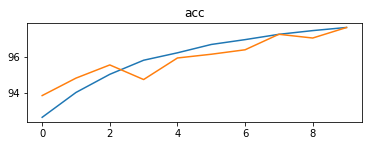

In [16]:
device=(torch.device('cuda') if torch.cuda.is_available() else  torch.device('cpu'))
print(device)
learning_rate=0.9
optimizer=torch.optim.SGD(LeNet.parameters(),lr=learning_rate)
loss_fn=nn.CrossEntropyLoss()
epochs=10
train_loop(LeNet,device,train_loader,test_loader,optimizer,loss_fn,epochs=epochs)